IMPORTACION DEL DATASET

In [26]:
import pandas as pd

url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', names=["label", "text"])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head(20)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


PREPROCESAMIENTO DEL DATASET

In [27]:
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') 
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def clean_text(text):
    # 1. Minúsculas
    text = text.lower()
    # 2. Eliminar todo lo que no sea letras o espacios
    text = re.sub(r"[^a-z\s]", " ", text)
    # 3. Tokenización
    tokens = nltk.word_tokenize(text)
    # 4. Eliminar stopwords y palabras cortas
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    # 5. Reconstrucción
    return " ".join(tokens)

# Aplicar al dataset
df['clean_text'] = df['text'].astype(str).apply(clean_text)

# Comparar texto original vs limpio
df[['text','clean_text']].head(20)


[nltk_data] Downloading package stopwords to /home/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/chris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/chris/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...
1,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,dun say early hor already say
4,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling week word back like fun st...
6,Even my brother is not like to speak with me. ...,even brother like speak treat like aids patent
7,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
8,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...
9,Had your mobile 11 months or more? U R entitle...,mobile months entitled update latest colour mo...


SELECCION DE CARACTERISTICAS (TD-IDF + CHI-CUADRADO)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # máximo 5000 palabras
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']
print("Dimension Matriz TF-IDF:", X.shape)

# Selección de características con chi-cuadrado
k = 1000  # número de features a conservar
selector = SelectKBest(chi2, k=k)
X_new = selector.fit_transform(X, y)

print("Dimension Matriz después de selección:", X_new.shape)

# Obtener las palabras más importantes del dataset
selected_features = [vectorizer.get_feature_names_out()[i] 
                     for i in selector.get_support(indices=True)]

print("Ejemplo de features seleccionadas:", selected_features[:10])



Dimension Matriz TF-IDF: (5572, 5000)
Dimension Matriz después de selección: (5572, 1000)
Ejemplo de features seleccionadas: ['ab', 'abta', 'ac', 'access', 'accident', 'account', 'acl', 'aco', 'action', 'activate']


APRENDIZAJE SUPERFICIAL - SVM

🔹 Resultados del Modelo SVM
🔹 Accuracy: 0.9820627802690582

🔹 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



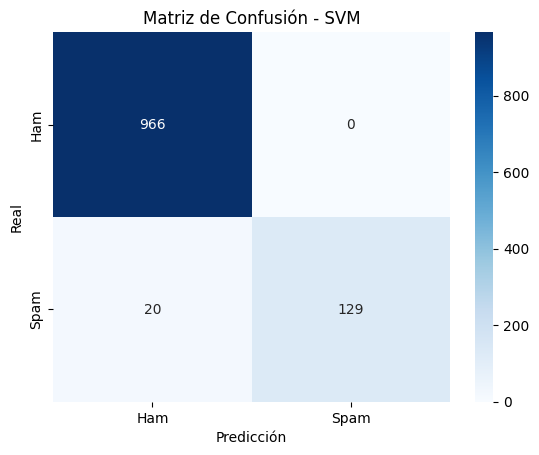

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Definir y entrenar modelo SVM
svm_model = SVC(kernel="linear", C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# 3. Predecir en test
y_pred = svm_model.predict(X_test)

# 4. Métricas
print("🔹 Resultados del Modelo SVM")
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Reporte de Clasificación:\n", classification_report(y_test, y_pred))

# 5. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVM")
plt.show()

# 6. Guardar predicciones para comparación futura
y_pred_svm = y_pred
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
acc_svm = accuracy_score(y_test, y_pred)
precision_svm = report_svm['1']['precision']
recall_svm = report_svm['1']['recall']
f1_svm = report_svm['1']['f1-score']

APRENDIZAJE PROFUNDO - MLP

Epoch 1/10, Loss: 0.6234
Epoch 2/10, Loss: 0.1943
Epoch 3/10, Loss: 0.0609
Epoch 4/10, Loss: 0.0360
Epoch 5/10, Loss: 0.0258
Epoch 6/10, Loss: 0.0195
Epoch 7/10, Loss: 0.0159
Epoch 8/10, Loss: 0.0129
Epoch 9/10, Loss: 0.0112
Epoch 10/10, Loss: 0.0099

🔹 Resultados del Modelo MLP
🔹 Accuracy (MLP): 0.9847533632286996

🔹 Reporte de Clasificación (MLP):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.90      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



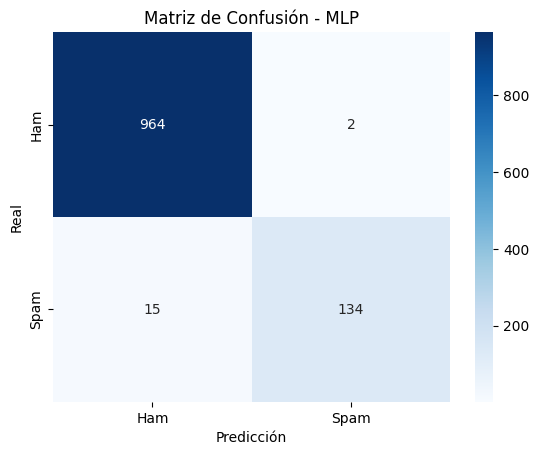

In [45]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from mlp import PyTorchMLP
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Convertir X y Y a tensores
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# 2. Crear DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# 3. Definir modelo
num_features = X_train_tensor.shape[1]
num_classes = 2
model = PyTorchMLP(num_features, num_classes)

# 4. Definir optimizador y función de pérdida
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. Entrenamiento
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# 6. Evaluación
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(preds.tolist())

# Métricas
acc_mlp = accuracy_score(y_true, y_pred)
y_pred_mlp = y_pred
y_true_mlp = y_true

# Presentar resultados
print("\n🔹 Resultados del Modelo MLP")
print("🔹 Accuracy (MLP):", accuracy_score(y_true, y_pred))
print("\n🔹 Reporte de Clasificación (MLP):\n", classification_report(y_true, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - MLP")
plt.show()

# 6. Guardar predicciones para comparación futura
y_pred_mlp = y_pred
report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)
acc_mlp = accuracy_score(y_test, y_pred)
precision_mlp = report_mlp['1']['precision']
recall_mlp = report_mlp['1']['recall']
f1_mlp = report_mlp['1']['f1-score']


COMPARACION DE RESULTADOS

,Modelo,Accuracy,Precision,Recall,F1-Score
0,SVM,0.9821,1.0000,0.8658,0.9281
1,MLP,0.9848,0.9853,0.8993,0.9404


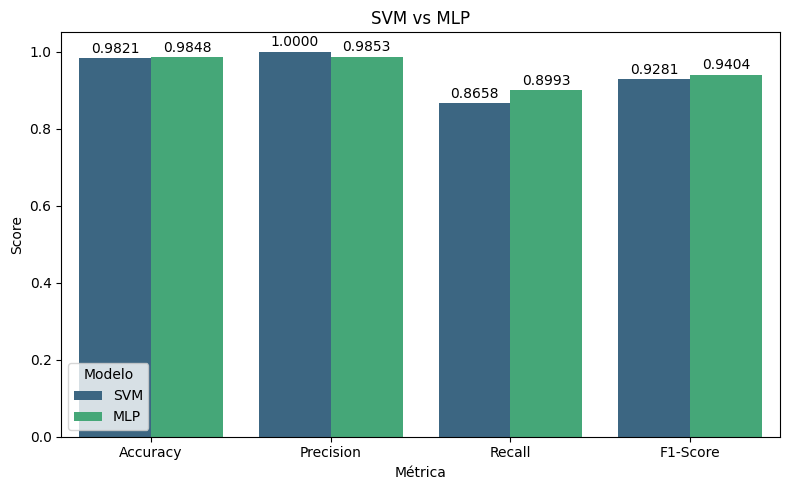

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comparación de métricas
results = pd.DataFrame({
    "Modelo": ["SVM", "MLP"],
    "Accuracy": [float(acc_svm), float(acc_mlp)],
    "Precision": [float(precision_svm), float(precision_mlp)],
    "Recall": [float(recall_svm), float(recall_mlp)],
    "F1-Score": [float(f1_svm), float(f1_mlp)]
})

# Mostrar en tabla
display(
    results.style
    .format({col: "{:.4f}" for col in results.columns if results[col].dtype != "object"})
    .set_caption(" Comparación de Métricas entre Modelos")
)

# Gráfica comparativa
plt.figure(figsize=(8,5))
results_melt = results.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")
ax = sns.barplot(data=results_melt, x="Métrica", y="Valor", hue="Modelo", palette="viridis")
for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", label_type="edge", padding=2)
plt.ylim(0, 1.05)
plt.title("SVM vs MLP")
plt.ylabel("Score")
plt.xlabel("Métrica")
plt.legend(title="Modelo")
plt.tight_layout()
plt.show()




